In [2]:
%%capture
!pip install git+https://github.com/source-separation/tutorial

In [5]:
import warnings
warnings.simplefilter('ignore')
import nussl

In [4]:
!pip install SoX

In [6]:
# Let's download a file from the External File Zoo
input_file_path = nussl.efz_utils.download_audio_file('schoolboy_fascination_excerpt.wav')

Saving file at /root/.nussl/audio/schoolboy_fascination_excerpt.wav
schoolboy_fascination_excerpt.wav...100%


In [7]:
signal1 = nussl.AudioSignal(input_file_path)

In [8]:
print(signal1)

AudioSignal (unlabeled): 15.000 sec @ /root/.nussl/audio/schoolboy_fascination_excerpt.wav, 44100 Hz, 2 ch.


In [9]:
_ = signal1.embed_audio()

signalを聞くためにembed audioする必用がある.

In [11]:
print("Duration: {} seconds".format(signal1.signal_duration))
print("Duration in samples: {} samples".format(signal1.signal_length))
print("Number of channels: {} channels".format(signal1.num_channels))
print("File name: {}".format(signal1.file_name))
print("Full path to input: {}".format(signal1.path_to_input_file))
print("Root mean square energy: {:.4f}".format(signal1.rms().mean()))

Duration: 15.0 seconds
Duration in samples: 661500 samples
Number of channels: 2 channels
File name: schoolboy_fascination_excerpt.wav
Full path to input: /root/.nussl/audio/schoolboy_fascination_excerpt.wav
Root mean square energy: 0.1136


AudioSignal には有用なファンクションが多く含まれている．

実際の信号データは，signal1.audio_dataに入っている．numpy配列であるので便利！

In [13]:
signal1.audio_data

array([[ 0.00213623, -0.04547119, -0.0513916 , ..., -0.24395752,
        -0.2310791 , -0.20785522],
       [-0.1791687 , -0.20150757, -0.20574951, ..., -0.23834229,
        -0.2156372 , -0.168396  ]], dtype=float32)

In [15]:
signal1.audio_data.shape

(2, 661500)

1,AudioSignalがファイルをロードすると，データは-1から1の範囲のfloatに変換される．
2,最初の次元にチャネル数が入っており，2番めの次元がサンプル方向．

AudioSignalオブジェクトを初期化するもう一つの方法として，numpy配列を渡すことが上げられる．
下記は，numpy配列内で単一チャネル信号を作成した例である．

In [18]:
import numpy as np

sample_rate = 44100  # Hz
dt = 1.0 / sample_rate
dur = 2.0  # seconds
freq = 440  # Hz
x = np.arange(0.0, dur, dt)
x = np.sin(2 * np.pi * freq * x)

In [19]:
signal2 = nussl.AudioSignal(audio_data_array=x, sample_rate=sample_rate)
signal2.embed_audio()
print(signal2)

AudioSignal (unlabeled): 2.000 sec @ path unknown, 44100 Hz, 1 ch.


In [21]:
print(f"Default sample rate: {nussl.constants.DEFAULT_SAMPLE_RATE}")

Default sample rate: 44100


Other Basic Manipulations¶

2つの信号にオーディオデータを追加したい場合簡単であるが，そのまま足し算するとエラーになる．

In [22]:
signal3 = signal1 + signal2

AudioSignalException: ignored

現在は，Signal1がステレオ信号であり，Signal2がモノラルなので，足し合わせることができない．そのため，片方をモノラルにすれば，強引に足し合わせることはできる．

nusslはすべてのサンプルで2つのチャネルを単純に平均することで，足し合わせを行う．
上記を明示的にnusslに伝える必用があるため，overwrite=Trueとする必用がある．

In [24]:
print(signal1.to_mono(overwrite=True))

AudioSignal (unlabeled): 15.000 sec @ /root/.nussl/audio/schoolboy_fascination_excerpt.wav, 44100 Hz, 1 ch.


In [25]:
signal3 = signal1 + signal2

AudioSignalException: ignored

signal1, signal2の間で長さが違うというエラーが発生しているので，継続時間を秒単位で一致させることでこれを修正する．

In [26]:
signal1.truncate_seconds(signal2.signal_duration)
print(signal1)

AudioSignal (unlabeled): 2.000 sec @ /root/.nussl/audio/schoolboy_fascination_excerpt.wav, 44100 Hz, 1 ch.


ようやく足し合わせることができるようになる．
ここではオーディオデータのピーク正規化も行う
ピーク正規化についての補足資料
http://help.nchsoftware.com/help/jp/wavepad/win/normalize.html#:~:text=%E9%9F%B3%E9%87%8F%E3%81%AE%E6%9C%80%E5%A4%A7%E5%80%A4%E3%81%8C,%E6%AD%A3%E8%A6%8F%E5%8C%96%E3%81%A8%E8%A8%80%E3%81%84%E3%81%BE%E3%81%99%E3%80%82&text=%E6%AD%A3%E8%A6%8F%E5%8C%96%E3%82%92%E8%A1%8C%E3%81%86%E3%81%93%E3%81%A8,%E6%AD%A3%E8%A6%8F%E5%8C%96%E3%82%92%E8%A1%8C%E3%81%84%E3%81%BE%E3%81%99%E3%80%82

In [27]:
signal3 = signal1 + signal2
signal3.peak_normalize()
signal3.embed_audio()
print(signal3)

AudioSignal (unlabeled): 2.000 sec @ /root/.nussl/audio/schoolboy_fascination_excerpt.wav, 44100 Hz, 1 ch.


ようやく合成できたわーーめでたしめでたし．

とりあえず保存

In [28]:
signal3.write_audio_to_file('/tmp/signal3.wav')

Time-frequency representations

音源分離アルゴリズムの多くは時間領域ではなく，周波数領域で演算を行う．
nusslには短時間フーリエ変換（STFT)データを扱うためのインターフェースが用意されている．

signal1を初期化する．
下記は失敗例

In [29]:
signal1 = nussl.AudioSignal(input_file_path)
print('STFT Data:', signal1.stft_data)

STFT Data: None


signal1はwavファイルから初期化されたので，デフォルトでは，周波数領域データが含まれていないので，次のようにする

In [30]:
stft = signal1.stft()
print(stft.shape)

(1025, 1293, 2)


これでSTFTがAudioSignalオブジェクトにどのように格納されているかを調べることができる．
stft dataはsignal1.stft_dataに格納されている．
ここでnumpy型は複素数なのでそこは注意

In [31]:
signal1.stft_data.shape

(1025, 1293, 2)

最初の次元は各ホップで取得されたFFTビンの数を表して，2番目の次元は信号の長さ（ホップ単位）で，三番目の次元はチャネル数が入っている．

In [ ]:
とりあえずパワースペクトログラムへ変換

In [32]:
# np.abs(signal1.stft_data) ** 2
psd = signal1.power_spectrogram_data
print(psd.shape)

(1025, 1293, 2)


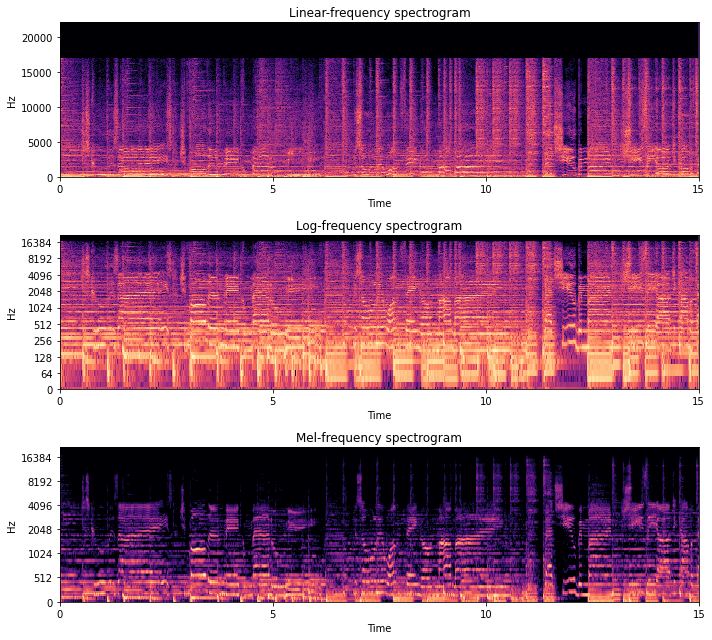

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 9))
plt.subplot(311)
plt.title('Linear-frequency spectrogram')
nussl.utils.visualize_spectrogram(signal1)

plt.subplot(312)
plt.title('Log-frequency spectrogram')
nussl.utils.visualize_spectrogram(signal1, y_axis='log')

plt.subplot(313)
plt.title('Mel-frequency spectrogram')
nussl.utils.visualize_spectrogram(signal1, y_axis='mel')

plt.tight_layout()
plt.show()

Inverse STFTs

ローパスフィルタ実装
信号の1000Hz以上の周波数を削ってゆく



In [35]:
import numpy as np

lp_stft = signal1.stft_data.copy()
lp_cutoff = 1000  # Hz
frequency_vector = signal1.freq_vector  # a vector of frequency values for each FFT bin
idx = (np.abs(frequency_vector - lp_cutoff)).argmin()  # trick to find the index of the closest value to lp_cutoff
lp_stft[idx:, :, :] = 0.0j  # every freq above lp_cutoff is 0 now

In [36]:
signal1_lp = signal1.make_copy_with_stft_data(lp_stft)
print('Audio Data:', signal1_lp.audio_data)

Audio Data: None


時系列データではなくSTFTで初期化できたので，新しいAudioSignalオブジェクトが作成された．
結果を聞くために逆STFTをして時系列データへ戻す．

In [37]:
signal1_lp.istft()
signal1_lp.embed_audio()
print(signal1_lp)

AudioSignal (unlabeled): 15.000 sec @ /root/.nussl/audio/schoolboy_fascination_excerpt.wav, 44100 Hz, 2 ch.


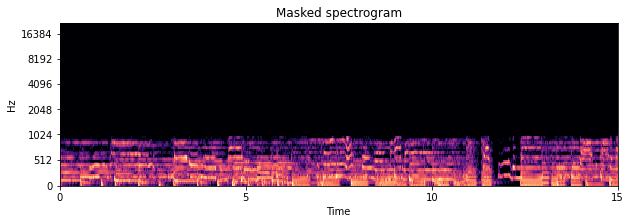

In [38]:
plt.figure(figsize=(10, 3))
plt.title('Masked spectrogram')
nussl.utils.visualize_spectrogram(signal1_lp, y_axis='mel')
plt.show()

ローパスフィルタかかってますね．

STFTのParameterについて

* window_length:fftを実行するウインドウの長さ．
* hop_length: window間のホップ量
* window_type: どのような窓関数を使用するか．

In [ ]:
さっきのやつのパラメータを見てみる．

In [39]:
signal1.stft_params

STFTParams(window_length=2048, hop_length=512, window_type='sqrt_hann')

STFTパラメータは、オーディオ信号の特性に基づいた有用なデフォルト値を使用して構築されています。32ミリ秒のウィンドウを使用し、ウィンドウ間は8ミリ秒でホップします。44100Hzの場合、窓の長さは2048、ホップの長さは512となります。ウィンドウタイプはsqrt_hannウィンドウで、これは全体的に分離性能が高いことがわかっています。使用可能なウィンドウは多数あります。

窓関数の種類を見てみる

In [40]:
nussl.constants.ALL_WINDOWS

['hamming', 'rectangular', 'hann', 'blackman', 'triang', 'sqrt_hann']

In [41]:
signal1.stft_params = nussl.STFTParams(
    window_length=256, hop_length=128)
signal1.stft().shape

(129, 5169, 2)

パラメータを変えて実行してみた例．
window_lengthが256の場合フレームごとに129の分析頻度が発生することに注意． (window_length // 2) + 1で求まる．